In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import inspect
import datetime
from scipy.spatial import distance
from sklearn.linear_model import LinearRegression
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
import Lyapunov_funcs as ly

# Generate test data
## Define logistic function

In [3]:
# define function
def logistic_fn(mu,xi):
    return mu*xi * (1-xi)


# compute function
def compute_fn (mu,x0 = 1e-99, length = 500):
    
    function = []

    for i in range(0,length): # generate array with index 0 -> 99
        if i == 0:
            function.append(x0)
        else:
            previous_value = function[i - 1]
            function.append(logistic_fn(mu,previous_value))
            
    return function

In [4]:
mu = np.arange(0, 4, 0.0004)
bifurcation = []

for i in mu:
    population = compute_fn(mu = i)[-1]
    bifurcation.append([i,population])
    
bifurcation = np.array(bifurcation)

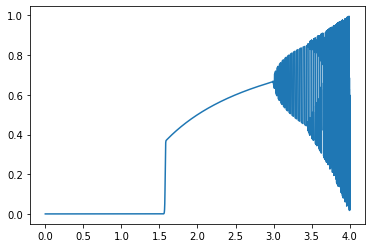

In [5]:
plt.plot(bifurcation[:,0], bifurcation[:,1]);

## Generate test data set from logistic function

Function defined by:
$$ x_{i+1} = \mu x_{i} (1-x_{i}) $$ 

Rosenstein used $\mu$ = 4, $\Delta$t = 1. This gives a value for $\lambda_{1}$ = 0.678 when N = 500, J = 2, m = 2

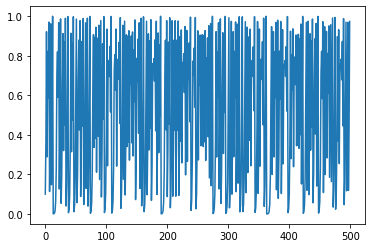

In [6]:
logistic_data = compute_fn(mu = 4, x0 = 0.1, length = 500)

plt.plot(logistic_data);

In [8]:
logistic_data

[0.1,
 0.36000000000000004,
 0.9216,
 0.28901376000000006,
 0.8219392261226498,
 0.5854205387341974,
 0.970813326249438,
 0.11333924730376121,
 0.4019738492975123,
 0.9615634951138128,
 0.1478365599132853,
 0.5039236458651636,
 0.9999384200124991,
 0.0002463047816241282,
 0.0009849764623147091,
 0.00393602513473358,
 0.015682131363489303,
 0.061744808477550275,
 0.23172954841448365,
 0.7121238592244125,
 0.8200138733909665,
 0.5903644833492417,
 0.9673370405960985,
 0.1263843619475224,
 0.4416454200105602,
 0.9863789719770243,
 0.05374198247429209,
 0.2034151271760999,
 0.6481496528481241,
 0.9122067214439212,
 0.3203424751858141,
 0.8708926951105607,
 0.44975443485449873,
 0.9899015327328368,
 0.039985952904069075,
 0.15354830589769058,
 0.5198848946145593,
 0.9984183638646715,
 0.006316538249855565,
 0.025106558377574705,
 0.09790487641603256,
 0.35327804635997584,
 0.9138906732802184,
 0.3147780422865899,
 0.8627713055232469,
 0.4735879195558363,
 0.997209608026444,
 0.0111304227447

## Calculate mean period of time series 

$$\mu = 1/T $$

Where T is the mean period of the time series' power spectrum

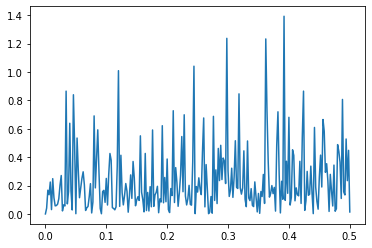

In [9]:
plt.plot(periodogram(logistic_data)[0],periodogram(logistic_data)[1])

In [10]:
def calc_mean_period (timeseries):
    power_spectrum = periodogram(timeseries)[1]
    frequencies = periodogram(timeseries)[0]

    
    weights = power_spectrum / sum(power_spectrum)
    return 1/np.average(frequencies, weights = weights)

## Put data into phase space

Each row represents a different value for i

Each column is a different j value 

Total length of each column is M

Total width of matrix is m (embedding dimension)

Each column seperated by lag J 

First value of each row represents the original time series

In [11]:
def gen_phase_space_matrix(timeseries, J, m):

    matrix = pd.DataFrame(columns = np.arange(0,m))
    
    for i, val in enumerate(timeseries):
     
        x_i = []

        for it in range(0, m):
            
            try:
                i_plus_j = timeseries[i + J*it]
                x_i.append(i_plus_j)
            except:
                x_i.append(np.nan)
        
        matrix.loc[i] = x_i
    return matrix
    

In [27]:
test_matrix = gen_phase_space_matrix(logistic_data, J=1, m=2)
test_matrix = test_matrix.dropna()
test_matrix

,0,1
0,0.100000,0.360000
1,0.360000,0.921600
2,0.921600,0.289014
3,0.289014,0.821939
4,0.821939,0.585421
...,...,...
494,0.116731,0.412420
495,0.412420,0.969319
496,0.969319,0.118960
497,0.118960,0.419234


## Find initial distance to nearest neighbour

1. For first row (i = 0), search for the nearest neighbour - entry with the smallest Euclidian distance to the row (i.e. pass both rows of matrix as m-dimensional points to euclidian function). This is distance dj(0)

2. Calculate the distance between these points for the following rows to get dj(i). Resulting matrix of distances will be M rows long.

In [28]:
def euc_distance (p1, p2):
    try: 
        return distance.euclidean (p1,p2)
    except:
        return np.inf


def find_nearest_neighbour (dataframe, ref_index, mean_period, i_max = 25):
    
    dists = []
    ref_row = dataframe.iloc[ref_index, :]
        
    for i in range(0,dataframe.shape[0] - i_max):
        test_row = dataframe.iloc[i, :]
                
#         print("not equal = ",i != ref_index)  
#         print("mean period = ",abs(i-ref_index) > mean_period)  
#         print("combined = ",i != ref_index and abs(i-ref_index) > mean_period)  
#         print("")
            
        if i != ref_index and abs(i-ref_index) > mean_period:
            dist = euc_distance(ref_row, test_row)
        else:
            dist = np.inf
            
        dists.append(dist)
        
    dists = pd.DataFrame(dists,columns = ['euc_distance'])
    dists = dists.sort_values(by = 'euc_distance', ascending = True)                  
    
    return dists.head(1).index.values[0]


In [29]:
mean_period = calc_mean_period(logistic_data)

In [30]:
NN_pairs = []

for i in range(0,test_matrix.shape[0]):
    NN = find_nearest_neighbour(test_matrix, ref_index= i, mean_period = mean_period)
    NN_pairs.append([i,NN])

In [31]:
NN_pairs

[[0, 306],
 [1, 307],
 [2, 308],
 [3, 309],
 [4, 310],
 [5, 311],
 [6, 312],
 [7, 313],
 [8, 418],
 [9, 419],
 [10, 360],
 [11, 361],
 [12, 189],
 [13, 190],
 [14, 191],
 [15, 448],
 [16, 449],
 [17, 450],
 [18, 451],
 [19, 452],
 [20, 282],
 [21, 283],
 [22, 284],
 [23, 285],
 [24, 286],
 [25, 287],
 [26, 288],
 [27, 289],
 [28, 290],
 [29, 434],
 [30, 59],
 [31, 356],
 [32, 68],
 [33, 69],
 [34, 70],
 [35, 71],
 [36, 396],
 [37, 397],
 [38, 276],
 [39, 277],
 [40, 183],
 [41, 184],
 [42, 185],
 [43, 93],
 [44, 94],
 [45, 95],
 [46, 161],
 [47, 297],
 [48, 298],
 [49, 469],
 [50, 146],
 [51, 438],
 [52, 194],
 [53, 195],
 [54, 196],
 [55, 197],
 [56, 198],
 [57, 199],
 [58, 200],
 [59, 30],
 [60, 31],
 [61, 286],
 [62, 287],
 [63, 425],
 [64, 426],
 [65, 283],
 [66, 154],
 [67, 155],
 [68, 32],
 [69, 33],
 [70, 34],
 [71, 420],
 [72, 421],
 [73, 422],
 [74, 192],
 [75, 193],
 [76, 26],
 [77, 27],
 [78, 410],
 [79, 258],
 [80, 220],
 [81, 266],
 [82, 330],
 [83, 331],
 [84, 440],
 [85,

In [34]:
test_matrix.iloc[0,:]

0    0.10
1    0.36
Name: 0, dtype: float64

In [36]:
test_matrix.iloc[305,:]

0    0.974343
1    0.099994
Name: 305, dtype: float64

## Calculate divergence of nearest neighbours

In [16]:
def expected_log_distance(dataframe, NN_pairs, i_max = 25): 
    
    dj_data = []
    
    for i in range (0,i_max): # calculate divergence through i_max steps
        
        dj_i = []
    
        for k in range (0,(dataframe.shape[0] - i_max)): # compute for all nearest neighbour pairs 
            
            NN_1 = NN_pairs[k][0]
            NN_2 = NN_pairs[k][1]
            
            p1 = dataframe.iloc[NN_1 + i, :]
            p2 = dataframe.iloc[NN_2 + i, :]
            
            dj_i.append(euc_distance(p1,p2))
                
        
        dj_data.append([i,np.mean(np.log(dj_i))])
        

    return dj_data

In [17]:
lyaponov_data = pd.DataFrame(expected_log_distance(test_matrix, NN_pairs), columns = ['i','log(dj)'])

## Get Lyapunov exponent by linear fit

Lyapunov exponent $\lambda _{1}$ can be found from the following equation

$$ ln(d_{j}(i)) = \lambda _{1}i\Delta t + ln(d_{j}(0)) $$

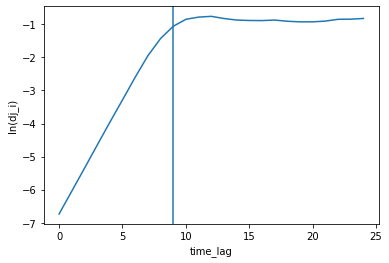

In [18]:
time_lag = 1

plt.plot(lyaponov_data['i']*time_lag, lyaponov_data['log(dj)'])
plt.xlabel('time_lag')
plt.ylabel('ln(dj_i)')

linearEnd = 9
plt.axvline(linearEnd) # reference line for estimating the end of linear section

plt.show()


In [19]:
#Hone in on linear section of curve
fit_data = lyaponov_data[0:linearEnd]

x = fit_data['i'].values.reshape(-1,1)
y = fit_data['log(dj)'].values.reshape(-1,1)

In [20]:
regressor = LinearRegression()  
regressor.fit(x,y)

Lyapunov_trend = regressor.predict(x)




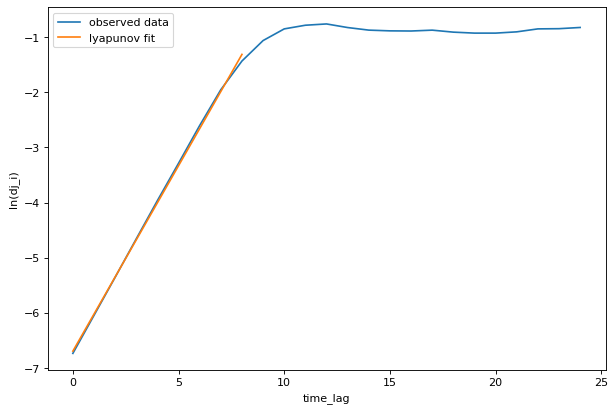

First Lyapunov exponent is:  0.6724991365569405


In [21]:
fig=plt.figure(figsize=(9, 6), dpi= 80, facecolor='w', edgecolor='k')



plt.plot(lyaponov_data['i']*time_lag, lyaponov_data['log(dj)'], label = 'observed data')
plt.xlabel('time_lag')
plt.ylabel('ln(dj_i)')

plt.plot(x,Lyapunov_trend, label = 'lyapunov fit')

plt.legend(loc = 'best')

plt.show()

print("First Lyapunov exponent is: ", regressor.coef_[0][0])

# 20 Feb meeting

### Presentation 1 feedback
- Eigenvectors and eigenvalues (?)
- Meet before final presentation
- Final presentation - more an extension of what we've already done than a rewrite 
- Focus away from complexity and more on the dynamical system 
- Taken's theorum - explain lagging/phase space transform 
- Next presentation - give recap, but keep up momentum
- Dick James to read final report

### Lyapunov
- Use hourly data rather than daily - costs money, cry about how we're students and see if they give it us for free
- "Certain russian website" with hourly or minutely data - look for American company names 
- "hiroki sayama - introduction to modelling and analysis of complex systems" free textbook to "borrow/steal/cite"
- Print off and sign NDA 
- Ask James Ratcliffe about Comp A
- Simon Crampin's material might give a hint 
- Will and Conor's reports are the best 
- Contact Will Bewley 
- Weight data to remove perturbations???
- Last year's group said hourly works better 
- Consider hourly as well as daily??
- Compare lyapunov for 2 days vs lyapunov for 48 hours of data - Do the answers agree?


In [22]:
plot_acf(x['Open'])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

# Test Lyapunov_funcs.py 

In [9]:
test_period = ly.calc_mean_period(logistic_data)

In [10]:
test_M = ly.gen_phase_space_matrix(logistic_data, J=1, m=2)

In [11]:
test_NN = ly.compute_nearest_neighbours(test_M,test_period)

In [13]:
test_div_data = pd.DataFrame(ly.expected_log_distance(test_M, test_NN), columns = ['i','log(dj)'])

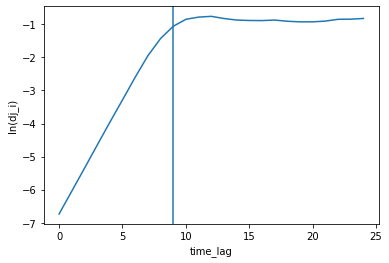

In [14]:
time_lag = 1

plt.plot(test_div_data['i'], test_div_data['log(dj)'])
plt.xlabel('time_lag')
plt.ylabel('ln(dj_i)')

linearEnd = 9
plt.axvline(linearEnd) # reference line for estimating the end of linear section

plt.show()